In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [122]:
#Machine Learning Libraries Python Imabalanced Scikit Learn 
from imblearn.metrics import classification_report_imbalanced 
from imblearn.ensemble import EasyEnsembleClassifier  # AddaBoost 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV and Perform Basic Data Cleaning

In [6]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [7]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


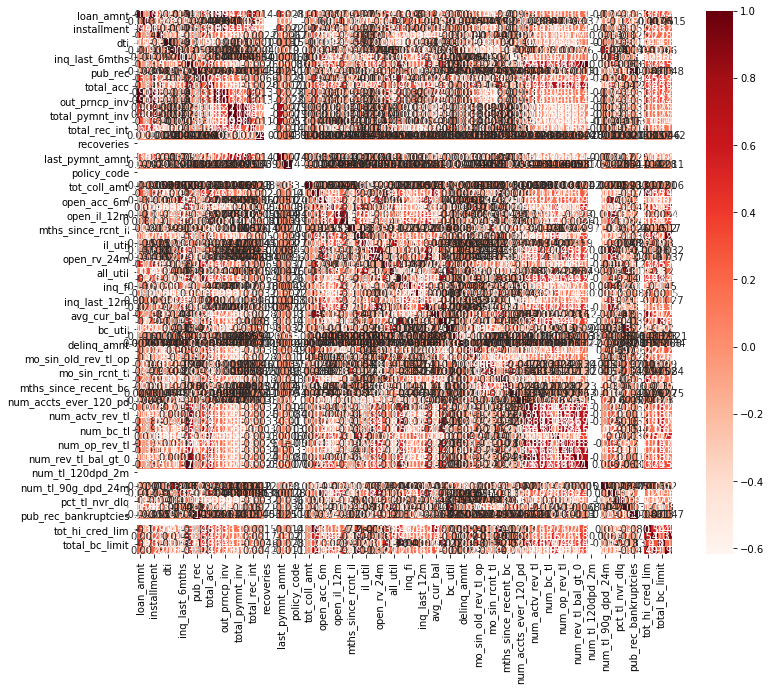

In [61]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [37]:
df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

# Split the Data into Training and Testing

In [71]:
# Create our features
X = df.copy()
X = X.drop("loan_status", axis=1)
X = pd.get_dummies(X)
# Create our target
y = df["loan_status"]


In [73]:
X

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,9.60,0.0,0.0,9.0,0.0,2684.0,...,0,1,0,1,0,1,1,0,1,1
68813,12000.0,0.2727,368.37,63000.0,29.07,0.0,0.0,8.0,0.0,13314.0,...,0,1,0,1,0,1,1,0,1,1
68814,5000.0,0.1992,185.62,52000.0,14.86,0.0,0.0,5.0,1.0,3715.0,...,0,1,0,1,0,1,1,0,1,1
68815,40000.0,0.0646,1225.24,520000.0,9.96,0.0,1.0,21.0,0.0,59529.0,...,0,1,1,0,0,1,1,0,1,1


In [74]:
Counter(y)

Counter({'low_risk': 68470, 'high_risk': 347})

In [75]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

In [69]:
X_test

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
7034,10000.0,0.1308,337.33,RENT,65000.0,Not Verified,Mar-2019,n,33.30,2.0,...,73.1,100.0,0.0,0.0,64950.0,31265.0,6900.0,55850.0,N,N
38804,10275.0,0.1614,250.64,MORTGAGE,107000.0,Source Verified,Jan-2019,n,17.05,0.0,...,100.0,0.0,1.0,0.0,581350.0,32199.0,27400.0,36550.0,N,N
65533,40000.0,0.0819,1256.97,MORTGAGE,170000.0,Source Verified,Jan-2019,n,14.33,0.0,...,100.0,100.0,0.0,0.0,498383.0,64318.0,23800.0,59638.0,N,N
37736,9000.0,0.1356,305.68,MORTGAGE,98000.0,Source Verified,Jan-2019,n,17.17,0.0,...,81.0,20.0,0.0,0.0,395766.0,55720.0,22500.0,47941.0,N,N
6390,9100.0,0.1640,321.73,MORTGAGE,90000.0,Not Verified,Mar-2019,n,20.92,0.0,...,97.0,100.0,0.0,0.0,165468.0,67114.0,13400.0,68268.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31854,20000.0,0.2235,556.37,RENT,62000.0,Not Verified,Feb-2019,n,18.91,0.0,...,100.0,100.0,0.0,0.0,40460.0,25831.0,13600.0,25160.0,N,N
27835,20000.0,0.0702,617.73,RENT,90000.0,Not Verified,Feb-2019,n,29.73,0.0,...,100.0,80.0,0.0,0.0,142673.0,94363.0,40000.0,96673.0,N,N
3089,15000.0,0.1557,361.36,MORTGAGE,50000.0,Not Verified,Mar-2019,n,17.23,0.0,...,100.0,50.0,0.0,0.0,136000.0,16351.0,6000.0,15000.0,N,N
43343,5600.0,0.1131,184.17,RENT,50000.0,Not Verified,Jan-2019,n,0.84,1.0,...,83.3,0.0,0.0,0.0,23024.0,15682.0,2500.0,15524.0,N,N


# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [76]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# YOUR CODE HERE
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [99]:
X_resampled

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,1600.0,0.0881,50.74,35964.0,24.12,0.0,0.0,20.0,0.0,1156.0,...,1,1,1,0,0,1,1,0,1,1
1,9000.0,0.0756,280.21,41000.0,16.89,1.0,0.0,16.0,0.0,11157.0,...,0,1,0,1,0,1,1,0,1,1
2,10000.0,0.1033,214.10,112000.0,17.75,0.0,0.0,14.0,0.0,16904.0,...,0,1,0,1,0,1,1,0,1,1
3,36000.0,0.1033,1167.21,120000.0,19.95,0.0,1.0,13.0,0.0,63248.0,...,1,1,0,1,0,1,1,0,1,1
4,18000.0,0.0881,570.81,51000.0,19.11,1.0,0.0,16.0,0.0,17586.0,...,0,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102727,20000.0,0.1102,435.05,117000.0,11.72,0.0,0.0,24.0,0.0,10273.0,...,1,1,1,0,0,1,1,0,1,1
102728,10000.0,0.1356,339.65,101000.0,19.13,1.0,1.0,10.0,0.0,8398.0,...,0,1,0,1,0,1,1,0,1,1
102729,21000.0,0.0702,648.62,70000.0,16.42,0.0,2.0,9.0,0.0,2684.0,...,0,1,0,1,1,0,1,0,1,1
102730,20000.0,0.1502,693.51,36000.0,28.57,0.0,1.0,13.0,0.0,13674.0,...,0,1,0,1,0,1,0,1,1,1


In [100]:
y_resampled

0          low_risk
1          low_risk
2          low_risk
3          low_risk
4          low_risk
            ...    
102727    high_risk
102728    high_risk
102729    high_risk
102730    high_risk
102731    high_risk
Name: loan_status, Length: 102732, dtype: object

In [90]:
# Calculated the balanced accuracy score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
balanced_accuracy_score(y_test, y_pred)

0.6503524738582371

In [95]:
# Calculating the confusion matrix.
# Create a DataFrame from the confusion matrix.
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,70,31
Actual 1,6711,10393


Accuracy Score : 0.608137169427492
Classification Report
              precision    recall  f1-score   support

   high_risk       0.01      0.69      0.02       101
    low_risk       1.00      0.61      0.76     17104

    accuracy                           0.61     17205
   macro avg       0.50      0.65      0.39     17205
weighted avg       0.99      0.61      0.75     17205



In [97]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred)) 

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.61      0.02      0.65      0.42       101
   low_risk       1.00      0.61      0.69      0.76      0.65      0.42     17104

avg / total       0.99      0.61      0.69      0.75      0.65      0.42     17205



In [114]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)
# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [116]:
# Calculating the confusion matrix.
cmr = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cmr_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cmr_df
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
# Displaying results
print("Confusion Matrix - Random Forest Model")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix - Random Forest Model


,Predicted 0,Predicted 1
Actual 0,70,31
Actual 1,6711,10393


Accuracy Score : 0.9961057832025574
Classification Report
              precision    recall  f1-score   support

   high_risk       0.95      0.36      0.52       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.97      0.68      0.76     17205
weighted avg       1.00      1.00      1.00     17205



In [136]:
# List the features sorted in descending order by feature importance
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
# print(importances)
# We can sort the features by their importance.
print('Feature importance: ')

Feature importance: 


In [134]:
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.07398558864785992, 'last_pymnt_amnt'),
 (0.06884170173613287, 'total_rec_int'),
 (0.06523532676335252, 'total_rec_prncp'),
 (0.06374896905859563, 'total_pymnt'),
 (0.05464895816442248, 'total_pymnt_inv'),
 (0.02166572559078289, 'installment'),
 (0.02078375250816378, 'out_prncp'),
 (0.019700043083169395, 'out_prncp_inv'),
 (0.016746738616032708, 'dti'),
 (0.015373689128417491, 'mo_sin_old_il_acct'),
 (0.015355208935667861, 'mo_sin_old_rev_tl_op'),
 (0.014951272342444512, 'max_bal_bc'),
 (0.01464820012156692, 'tot_hi_cred_lim'),
 (0.014498153222565003, 'total_il_high_credit_limit'),
 (0.014432118242035354, 'total_bal_il'),
 (0.014311976505887591, 'loan_amnt'),
 (0.014220358077098556, 'total_bal_ex_mort'),
 (0.013892401062721584, 'total_bc_limit'),
 (0.013657715672034774, 'avg_cur_bal'),
 (0.013504539004018826, 'revol_bal'),
 (0.013112408627534159, 'bc_util'),
 (0.01298671228034472, 'tot_cur_bal'),
 (0.012906750330399461, 'annual_inc'),
 (0.012844561549107318, 'bc_open_to_buy'),
 (0.0

### Easy Ensemble AdaBoost Classifier

In [123]:
# Train the Classifier
eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X_train, y_train) # doctest: +ELLIPSIS
y_pred = eec.predict(X_test)

In [126]:
# Calculated the balanced accuracy score
# Calculating the confusion matrix.

cma = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cma_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cma_df
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
# Displaying results
print("Confusion Matrix - Easy Ensemble AdaBoost Classifier")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix - Easy Ensemble AdaBoost Classifier


,Predicted 0,Predicted 1
Actual 0,70,31
Actual 1,6711,10393


Accuracy Score : 0.9487939552455682
Classification Report
              precision    recall  f1-score   support

   high_risk       0.09      0.89      0.17       101
    low_risk       1.00      0.95      0.97     17104

    accuracy                           0.95     17205
   macro avg       0.55      0.92      0.57     17205
weighted avg       0.99      0.95      0.97     17205



In [129]:
# Print the imbalanced classification report
print('classification_report_imbalanced from imblearn.metrics')
print(classification_report_imbalanced(y_test, y_pred)) 

classification_report_imbalanced from imblearn.metrics
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.89      0.95      0.17      0.92      0.84       101
   low_risk       1.00      0.95      0.89      0.97      0.92      0.85     17104

avg / total       0.99      0.95      0.89      0.97      0.92      0.85     17205

